# Imports

In [12]:
import pandas as pd
import glob
import os
import numpy as np
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from tqdm.auto import tqdm
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
def check_missing_players(player_list, player_data):
    missing_players = []
    for game in player_list:
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
    return missing_players


def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(paths):
    all_data = []
    for i in range(len(paths)):
        df = pd.read_csv(paths[i], header=None)
        visiting_players = get_names(df, 105, 132)
        home_players = get_names(df, 132, 159)
        home_pitchers = df.iloc[:, 104].tolist()
        visiting_pitchers = df.iloc[:, 102].tolist()
        visiting_players = list_stacker(visiting_pitchers, visiting_players)
        home_players = list_stacker(home_pitchers, home_players)
        visiting_scores = df.iloc[:, 9].tolist()
        home_scores = df.iloc[:, 10].tolist()
        all_data.extend(list(zip(visiting_players, home_players, visiting_scores, home_scores)))
    return all_data


def get_player_data(paths):
    le = LabelEncoder()
    player_dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['Team'] = le.fit_transform(df['Team'])
        if 'Pos' in df.columns:
            df['Pos'] = le.fit_transform(df['Pos'])
        if 'Batters' not in path:
            df['ExtraCol1'] = 0
            df['ExtraCol2'] = 0
            df['ExtraCol3'] = 0
        df.columns = ['Player'] + list(range(len(df.columns) - 1))
        df['Player'] = df['Player'].str.lower()
        player_dfs.append(df)
    combined_player = pd.concat(player_dfs)
    combined_player = combined_player.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 0 # might need to flip
    else:
        label = 1
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))


def simulate_betting_season(bets, df, wallet_balance=1000.0):

    wallet_balance_history = [wallet_balance]  # Start with the initial wallet balance
    for bet in bets:
        bet_amount, bet_team, bet_date = bet
        row = df[(df['date'] == bet_date) & ((df['home_team'] == bet_team) | (df['visiting_team'] == bet_team))]
        if not row.empty and not row.isnull().values.any():
            if row['winner'].values[0]==1:
                winner = row['home_team'].values[0]
                if winner == bet_team:
                    if row['home_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['home_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['home_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            else:
                winner = row['visiting_team'].values[0]
                if winner == bet_team:
                    if row['visiting_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['visiting_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['visiting_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            wallet_balance_history.append(wallet_balance)
        else:
            print(f"No betting data for date: {bet_date}")
    return wallet_balance, wallet_balance_history


def get_player_vector(players, player_data):
    return [player_data[player.lower()] for player in players]


def predict_game_outcome(player_list, player_data, model, augment=False, base_bet=100, scaler=1):
    results, bets, skipped = [], [], []
    for i in range(len(player_list)):
        try:
            visiting_players = player_list.iloc[i][0][0]
            home_players = player_list.iloc[i][0][1]
            visiting_vector = get_player_vector(visiting_players, player_data)
            home_vector = get_player_vector(home_players, player_data)
            game_vector = [item for sublist in visiting_vector + home_vector for item in sublist]  # Flatten the vectors
            game_vector = torch.tensor([game_vector], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results.append(pred)
            bets.append(base_bet * prob * scaler if augment else base_bet)
        except:
            skipped.append(i)
    return results, bets, skipped


def generate_bets(results, bets, df, skipped):
    final_bets = []
    for i, (result, (_, row)) in enumerate(zip(results, df.iterrows())):
        if i in skipped:
            continue
        if result == 1:
            bet_team = row['home_team']
        else:
            bet_team = row['visiting_team']
        bet_date = row['date']
        final_bets.append((bets[i], bet_team, bet_date))
    return final_bets

# Data

In [3]:
def load_data(game_path, player_path, train_years, test_year):
    game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if str(test_year) not in path and any(str(year) in path for year in train_years)]
    game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if str(test_year) in path]

    player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if str(test_year) not in path and any(str(year) in path for year in train_years)]
    player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if str(test_year) in path]

    train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
    test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

    train_player_data = get_player_data(player_csvs_train)
    test_player_data = get_player_data(player_csvs_test)

    X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
    X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)
    print(game_csvs_train)
    print(player_csvs_train)
    print(game_csvs_test)
    print(player_csvs_test)
    return X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data

# load data
game_path = './game_data/'
player_path = './player_data/'

test_year = 2021
train_years = range(2010, test_year) #train years from 2010 to test year -1 for some reason range reduces the year by 1.

X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data = load_data(game_path, player_path, train_years, test_year)

player_path = './player_data/'
paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
for path in paths:
    df = pd.read_csv(path)
    view_data(df)

xlsx_path = './betting_odds/'
txt_path = './alldata/gamelogs/'
glfields_path = './alldata/gamelogs/glfields.txt'
paths = [path for path in glob(xlsx_path + '*.xlsx')]
paths_txt = [f'{txt_path}gl{test_year}.txt']
schedule_paths = [f'./alldata/schedules/{year}schedule.csv' for year in range(2010, 2024)]

100%|██████████| 2429/2429 [00:00<00:00, 37101.92it/s]


['./game_data/gl2010.txt', './game_data/gl2011.txt', './game_data/gl2012.txt', './game_data/gl2013.txt', './game_data/gl2014.txt', './game_data/gl2015.txt', './game_data/gl2016.txt', './game_data/gl2017.txt', './game_data/gl2018.txt', './game_data/gl2019.txt', './game_data/gl2020.txt']
['./player_data/mlb-player-stats-Batters_2015.csv', './player_data/mlb-player-stats-Batters_2016.csv', './player_data/mlb-player-stats-Batters_2017.csv', './player_data/mlb-player-stats-Batters_2018.csv', './player_data/mlb-player-stats-Batters_2019.csv', './player_data/mlb-player-stats-Batters_2020.csv', './player_data/mlb-player-stats-P_2015.csv', './player_data/mlb-player-stats-P_2016.csv', './player_data/mlb-player-stats-P_2017.csv', './player_data/mlb-player-stats-P_2018.csv', './player_data/mlb-player-stats-P_2019.csv', './player_data/mlb-player-stats-P_2020.csv']
['./game_data/gl2021.txt']
['./player_data/mlb-player-stats-Batters_2021.csv', './player_data/mlb-player-stats-P_2021.csv']
There are no

In [4]:
print(y_train)

       0
0      0
1      0
2      1
3      1
4      1
...   ..
11585  1
11586  0
11587  1
11588  1
11589  0

[11590 rows x 1 columns]


In [5]:
print(paths_txt)

['./alldata/gamelogs/gl2021.txt']


In [6]:


# # load data
# game_path = './game_data/'
# player_path = './player_data/'

# game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' in path]

# player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' in path]

# train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
# test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

# train_player_data = get_player_data(player_csvs_train)
# test_player_data = get_player_data(player_csvs_test)

# X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
# X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

In [7]:
xlsx_dataframes = []
for i, path in enumerate(paths):
    temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
    temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
    year = path[-9:-5]  # extract year from file name
    if 'Date' in temp_df.columns:
        temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
    xlsx_dataframes.append(temp_df)

try:
    xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
except pd.errors.InvalidIndexError:
    print('Error: Reindexing only valid with uniquely valued Index objects')

with open(glfields_path, 'r') as file:
    glfields_data = file.read()

xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

# Merge on 'date'
xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
print(xlsx_dataframes)
headers = [
    "date",
    "number_of_game",
    "day_of_week",
    "visiting_team",
    "visiting_team_league",
    "visiting_team_game_number",
    "home_team",
    "home_team_league",
    "home_team_game_number",
    "visiting_team_score",
    "home_team_score",
    "length_of_game_in_outs",
    "day_night_indicator",
    "completion_information",
    "forfeit_information",
    "protest_information",
    "park_id",
    "attendance",
    "time_of_game_in_minutes",
    "visiting_team_line_scores",
    "home_team_line_scores",
    "visiting_team_at_bats",
    "visiting_team_hits",
    "visiting_team_doubles",
    "visiting_team_triples",
    "visiting_team_homeruns",
    "visiting_team_RBI",
    "visiting_team_sacrifice_hits",
    "visiting_team_sacrifice_flies",
    "visiting_team_hit_by_pitch",
    "visiting_team_walks",
    "visiting_team_intentional_walks",
    "visiting_team_strikeouts",
    "visiting_team_stolen_bases",
    "visiting_team_caught_stealing",
    "visiting_team_grounded_into_double_plays",
    "visiting_team_awarded_first_on_catchers_interference",
    "visiting_team_left_on_base",
    "visiting_team_pitchers_used",
    "visiting_team_individual_earned_runs",
    "visiting_team_team_earned_runs",
    "visiting_team_wild_pitches",
    "visiting_team_balks",
    "visiting_team_putouts",
    "visiting_team_assists",
    "visiting_team_errors",
    "visiting_team_passed_balls",
    "visiting_team_double_plays",
    "visiting_team_triple_plays",
    "home_team_at_bats",
    "home_team_hits",
    "home_team_doubles",
    "home_team_triples",
    "home_team_homeruns",
    "home_team_RBI",
    "home_team_sacrifice_hits",
    "home_team_sacrifice_flies",
    "home_team_hit_by_pitch",
    "home_team_walks",
    "home_team_intentional_walks",
    "home_team_strikeouts",
    "home_team_stolen_bases",
    "home_team_caught_stealing",
    "home_team_grounded_into_double_plays",
    "home_team_awarded_first_on_catchers_interference",
    "home_team_left_on_base",
    "home_team_pitchers_used",
    "home_team_individual_earned_runs",
    "home_team_team_earned_runs",
    "home_team_wild_pitches",
    "home_team_balks",
    "home_team_putouts",
    "home_team_assists",
    "home_team_errors",
    "home_team_passed_balls",
    "home_team_double_plays",
    "home_team_triple_plays",
    "home_plate_umpire_id",
    "home_plate_umpire_name",
    "first_base_umpire_id",
    "first_base_umpire_name",
    "second_base_umpire_id",
    "second_base_umpire_name",
    "third_base_umpire_id",
    "third_base_umpire_name",
    "left_field_umpire_id",
    "left_field_umpire_name",
    "right_field_umpire_id",
    "right_field_umpire_name",
    "visiting_team_manager_id",
    "visiting_team_manager_name",
    "home_team_manager_id",
    "home_team_manager_name",
    "winning_pitcher_id",
    "winning_pitcher_name",
    "losing_pitcher_id",
    "losing_pitcher_name",
    "saving_pitcher_id",
    "saving_pitcher_name",
    "game_winning_rbi_batter_id",
    "game_winning_rbi_batter_name",
    "visiting_starting_pitcher_id",
    "visiting_starting_pitcher_name",
    "home_starting_pitcher_id",
    "home_starting_pitcher_name",
]
for i in range(1, 10):
    headers.extend([
        f"visiting_starting_player_{i}_id",
        f"visiting_starting_player_{i}_name",
        f"visiting_starting_player_{i}_defensive_position"
    ])

for i in range(1, 10):
    headers.extend([
        f"home_starting_player_{i}_id",
        f"home_starting_player_{i}_name",
        f"home_starting_player_{i}_defensive_position"
    ])

headers.extend(["additional_information", "acquisition_information"])

txt_dataframes = []
for path_txt in paths_txt:
    df = pd.read_csv(path_txt, delimiter = ",", quotechar='"', quoting=1, header = None)
    df.columns = headers
    txt_dataframes.append(df)
    # view_data(df)
# txt_dataframes = txt_dataframes.replace({',': '', '\"': ''}, regex=True)
# If you want to view the file in Excel, uncomment the following line
# os.startfile(xlsx_files[0])
# Concatenate all dataframes in txt_dataframes into a single dataframe
txt_dataframes_concat = pd.concat(txt_dataframes)

# Determine the winning team for each game and add it as a new column 'winner'
txt_dataframes_concat['winner'] = txt_dataframes_concat.apply(lambda row: 1 if row["home_team_score"] > row["visiting_team_score"] else 2 if row["home_team_score"] == row["visiting_team_score"] else 0, axis=1)

# Drop all columns except for the visiting and home pitchers, starting players, home_team, visiting_team, date, coach, and winner
# txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
#                                               'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
#                                               'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
#                                               'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
#                                               'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
#                                               'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
#                                               'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
#                                               'home_team_score','visiting_team_score','winner']]
txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'winner']]

xlsx_dataframes['date'] = xlsx_dataframes['date'].astype(int)
txt_dataframes_concat['date'] = txt_dataframes_concat['date']
# Now perform the merge operation
merged_dataframes = pd.merge(xlsx_dataframes, txt_dataframes_concat, on=['date', 'home_team', 'visiting_team'])
merged_dataframes_full = pd.merge(txt_dataframes_concat,xlsx_dataframes, on=['date', 'home_team', 'visiting_team'],how="left")

# Now, merged_data should only contain bets on actual games played

player_list_concat = pd.concat(txt_dataframes)
player_list_concat = player_list_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'home_team_score','visiting_team_score',
                                              'home_starting_player_1_defensive_position', 'home_starting_player_2_defensive_position', 
                                              'home_starting_player_3_defensive_position', 'home_starting_player_4_defensive_position', 
                                              'home_starting_player_5_defensive_position', 'home_starting_player_6_defensive_position', 
                                              'home_starting_player_7_defensive_position', 'home_starting_player_8_defensive_position', 
                                              'home_starting_player_9_defensive_position', 'visiting_starting_player_1_defensive_position', 
                                              'visiting_starting_player_2_defensive_position', 'visiting_starting_player_3_defensive_position', 
                                              'visiting_starting_player_4_defensive_position', 'visiting_starting_player_5_defensive_position', 
                                              'visiting_starting_player_6_defensive_position', 'visiting_starting_player_7_defensive_position', 
                                              'visiting_starting_player_8_defensive_position', 'visiting_starting_player_9_defensive_position']]

player_list_concat['lineup'] = player_list_concat.apply(lambda row: [
    (
        (row['visiting_starting_pitcher_name'],) +
        tuple(row[f'visiting_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'visiting_starting_player_{i}_defensive_position']))
    ),
    (
        (row['home_starting_pitcher_name'],) +
        tuple(row[f'home_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'home_starting_player_{i}_defensive_position']))
    ),
    # row['visiting_team_score'],
    # row['home_team_score']
], axis=1).tolist()

merged_player_dataframe = pd.merge(xlsx_dataframes, player_list_concat, on=['date', 'home_team', 'visiting_team'])

           date home_team visiting_team  home_open  visiting_open
0      20100404       BOS           NYY       -114           -106
1      20100405       WAS           PHI        170           -200
2      20100405       NYM           MIA       -115           -105
3      20100405       CIN           STL        135           -155
4      20100405       PIT           LOS        135           -155
...         ...       ...           ...        ...            ...
28001  20211027       HOU           ATL       -115           -105
28002  20211029       ATL           HOU       -115           -105
28003  20211030       ATL           HOU       -115           -105
28004  20211031       ATL           HOU       -105           -115
28005  20211102       HOU           ATL       -120            100

[28006 rows x 5 columns]


In [8]:
# xlsx_dataframes.to_csv('output.csv', index=False)

In [9]:
# print(merged_player_dataframe['lineup'])

# NN

In [10]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
model

neural_net(
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (input_layer): Linear(in_features=440, out_features=880, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=880, out_features=880, bias=True)
  )
  (output_layer): Linear(in_features=880, out_features=2, bias=True)
)

In [ ]:
train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [ ]:
patience = 15
best_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'  # File path for saving the best model

for epoch in range(50):  # number of epochs
    model.train()
    train_losses = []
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    print(f'Training Loss: {avg_train_loss}')

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            valid_losses.append(loss.item())

    avg_valid_loss = np.mean(valid_losses)
    print(f'Validation Loss: {avg_valid_loss}')

    # Save the model at each epoch
    epoch_model_path = f'model_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), epoch_model_path)

    # Update the best model if validation loss improves
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Evaluate the best model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Epoch 1: 100%|██████████| 182/182 [00:03<00:00, 54.44it/s]


Training Loss: 0.8583777861280756
Validation Loss: 0.7151386755354264


Epoch 2: 100%|██████████| 182/182 [00:03<00:00, 53.55it/s]


Training Loss: 0.6996900298438229
Validation Loss: 0.687273209585863


Epoch 3: 100%|██████████| 182/182 [00:03<00:00, 51.53it/s]


Training Loss: 0.6912359313650446
Validation Loss: 0.6867968667955959


Epoch 4: 100%|██████████| 182/182 [00:03<00:00, 54.87it/s]


Training Loss: 0.686951450921677
Validation Loss: 0.6840780605288113


Epoch 5: 100%|██████████| 182/182 [00:03<00:00, 59.63it/s]


Training Loss: 0.6836680943494314
Validation Loss: 0.6844814104192397


Epoch 6: 100%|██████████| 182/182 [00:03<00:00, 52.63it/s]


Training Loss: 0.6839826709621555
Validation Loss: 0.6778521993580986


Epoch 7: 100%|██████████| 182/182 [00:03<00:00, 56.41it/s]


Training Loss: 0.6804469853312105
Validation Loss: 0.6761293428785661


Epoch 8: 100%|██████████| 182/182 [00:03<00:00, 58.26it/s]


Training Loss: 0.6796490003119459
Validation Loss: 0.6809380878420437


Epoch 9: 100%|██████████| 182/182 [00:03<00:00, 60.50it/s]


Training Loss: 0.680054328926317
Validation Loss: 0.6760583467343274


Epoch 10: 100%|██████████| 182/182 [00:02<00:00, 64.28it/s]


Training Loss: 0.6801169501556145
Validation Loss: 0.6765492155271418


Epoch 11: 100%|██████████| 182/182 [00:03<00:00, 60.60it/s]


Training Loss: 0.6776300511517368
Validation Loss: 0.677814336384044


Epoch 12: 100%|██████████| 182/182 [00:02<00:00, 62.47it/s]


Training Loss: 0.6773723521075405
Validation Loss: 0.6756943955140955


Epoch 13: 100%|██████████| 182/182 [00:02<00:00, 61.28it/s]


Training Loss: 0.6769568746561533
Validation Loss: 0.6890953305889579


Epoch 14: 100%|██████████| 182/182 [00:03<00:00, 59.75it/s]


Training Loss: 0.6782946861707247
Validation Loss: 0.6748289290596458


Epoch 15: 100%|██████████| 182/182 [00:02<00:00, 63.65it/s]


Training Loss: 0.675188538137373
Validation Loss: 0.6789660699227277


Epoch 16: 100%|██████████| 182/182 [00:03<00:00, 60.55it/s]


Training Loss: 0.6768508098282657
Validation Loss: 0.6860882254207835


Epoch 17: 100%|██████████| 182/182 [00:03<00:00, 58.28it/s]


Training Loss: 0.6765026368282654
Validation Loss: 0.6760635586345897


Epoch 18: 100%|██████████| 182/182 [00:03<00:00, 58.49it/s]


Training Loss: 0.6740779195513044
Validation Loss: 0.6777999366030973


Epoch 19: 100%|██████████| 182/182 [00:03<00:00, 53.87it/s]


Training Loss: 0.6723132136758867
Validation Loss: 0.6731956566081327


Epoch 20: 100%|██████████| 182/182 [00:03<00:00, 56.22it/s]


Training Loss: 0.6708108589544401
Validation Loss: 0.6784254680661594


Epoch 21: 100%|██████████| 182/182 [00:03<00:00, 60.59it/s]


Training Loss: 0.6730342104539766
Validation Loss: 0.6879822752055


Epoch 22: 100%|██████████| 182/182 [00:03<00:00, 58.70it/s]


Training Loss: 0.6716325577798781
Validation Loss: 0.6768746674060822


Epoch 23: 100%|██████████| 182/182 [00:02<00:00, 64.48it/s]


Training Loss: 0.6704198341448229
Validation Loss: 0.6756021906347836


Epoch 24: 100%|██████████| 182/182 [00:02<00:00, 61.09it/s]


Training Loss: 0.6698532726738479
Validation Loss: 0.6743776447632733


Epoch 25: 100%|██████████| 182/182 [00:02<00:00, 62.64it/s]


Training Loss: 0.6698869178583334
Validation Loss: 0.6830199623809141


Epoch 26: 100%|██████████| 182/182 [00:02<00:00, 63.48it/s]


Training Loss: 0.6701690030621958
Validation Loss: 0.6761552428497988


Epoch 27: 100%|██████████| 182/182 [00:02<00:00, 61.64it/s]


Training Loss: 0.6702648650158892
Validation Loss: 0.6732281744480133


Epoch 28: 100%|██████████| 182/182 [00:02<00:00, 64.21it/s]


Training Loss: 0.6687562963464758
Validation Loss: 0.6811448212932137


Epoch 29: 100%|██████████| 182/182 [00:03<00:00, 60.19it/s]


Training Loss: 0.6663659133098938
Validation Loss: 0.686037400189568


Epoch 30: 100%|██████████| 182/182 [00:02<00:00, 62.87it/s]


Training Loss: 0.6676434380012554
Validation Loss: 0.6754954229382908


Epoch 31: 100%|██████████| 182/182 [00:02<00:00, 61.14it/s]


Training Loss: 0.6654597412753891
Validation Loss: 0.7080346433555379


Epoch 32: 100%|██████████| 182/182 [00:02<00:00, 62.33it/s]


Training Loss: 0.665435716673568
Validation Loss: 0.6873218259390663


Epoch 33: 100%|██████████| 182/182 [00:02<00:00, 64.91it/s]


Training Loss: 0.6628614906426314
Validation Loss: 0.6777744521113003


Epoch 34: 100%|██████████| 182/182 [00:02<00:00, 60.82it/s]


Training Loss: 0.66047434426926
Validation Loss: 0.7023855342584497
Early stopping triggered
Confusion Matrix:
[[314 675]
 [242 921]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.32      0.41       989
           1       0.58      0.79      0.67      1163

    accuracy                           0.57      2152
   macro avg       0.57      0.55      0.54      2152
weighted avg       0.57      0.57      0.55      2152



# Run Season

Number of games:  967
Predictions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]
Bets:  [20, 20, 20, 20, 20,

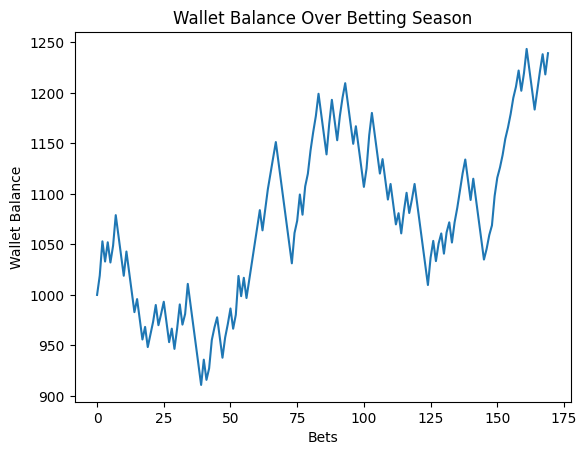

In [ ]:
date1, date2 = int(str(test_year)+'0101'), int(str(test_year+1)+'0101')
subset_df = merged_player_dataframe[(merged_player_dataframe['date'] >= date1) & (merged_player_dataframe['date'] <= date2)]
player_list = subset_df['lineup'].to_frame()

results, bets, skipped = predict_game_outcome(player_list, train_player_data, model, augment=False, scaler=10, base_bet=20)

final_bets = generate_bets(results, bets, subset_df, skipped)

print('Number of games: ', len(subset_df))
print('Predictions: ', results)
print('Bets: ', bets)

wallet_balance, wallet_balance_history = simulate_betting_season(final_bets, merged_dataframes)
print(wallet_balance)
print(wallet_balance_history)
plt.plot(wallet_balance_history)
plt.title('Wallet Balance Over Betting Season')
plt.xlabel('Bets')
plt.ylabel('Wallet Balance')
plt.show()

In [ ]:
len(merged_dataframes)

967

In [ ]:
print(final_bets)

[(20, 'PHI', 20210401), (20, 'DET', 20210401), (20, 'OAK', 20210401), (20, 'MIL', 20210401), (20, 'BOS', 20210402), (20, 'PHI', 20210403), (20, 'DET', 20210403), (20, 'BOS', 20210403), (20, 'OAK', 20210403), (20, 'MIL', 20210403), (20, 'PHI', 20210404), (20, 'BOS', 20210404), (20, 'MIL', 20210404), (20, 'TEX', 20210405), (20, 'WAS', 20210406), (20, 'MIN', 20210406), (20, 'TOR', 20210406), (20, 'ATL', 20210407), (20, 'WAS', 20210407), (20, 'ATL', 20210407), (20, 'ATL', 20210407), (20, 'COL', 20210407), (20, 'TOR', 20210407), (20, 'BOS', 20210408), (20, 'HOU', 20210408), (20, 'PHI', 20210409), (20, 'HOU', 20210409), (20, 'ATL', 20210410), (20, 'BAL', 20210410), (20, 'ARI', 20210411), (20, 'PHI', 20210411), (20, 'BAL', 20210411), (20, 'CLE', 20210411), (20, 'MIA', 20210412), (20, 'ARI', 20210412), (20, 'ATL', 20210413), (20, 'MIN', 20210413), (20, 'ARI', 20210413), (20, 'ATL', 20210414), (20, 'BOS', 20210414), (20, 'MIN', 20210414), (20, 'ATL', 20210415), (20, 'ARI', 20210415), (20, 'MIN'

In [ ]:
# len(final_bets)
len(train_player_data)

2679

# Misc

In [ ]:
missing_players = check_missing_players(player_list, train_player_data)
print('Missing players:', missing_players)
len(missing_players)

Missing players: ['l', 'i', 'n', 'e', 'u', 'p']


6

In [ ]:
print(skipped)
# for index in skipped:missing_players_per_game = []


[4, 12, 14, 16, 17, 20, 21, 24, 30, 32, 34, 37, 38, 41, 42, 43, 44, 50, 52, 56, 57, 58, 59, 60, 63, 65, 67, 71, 72, 73, 74, 75, 79, 80, 81, 87, 91, 92, 94, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 118, 119, 120, 122, 123, 124, 126, 132, 133, 135, 136, 139, 140, 143, 147, 150, 155, 156, 160, 161, 163, 166, 173, 176, 178, 181, 182, 187, 188, 193, 194, 195, 197, 202, 203, 205, 206, 211, 213, 216, 217, 221, 224, 226, 227, 228, 229, 231, 234, 235, 236, 238, 240, 241, 242, 243, 244, 245, 248, 252, 253, 257, 260, 261, 265, 267, 268, 270, 274, 275, 279, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 294, 295, 297, 298, 299, 300, 301, 307, 309, 311, 312, 313, 314, 315, 316, 319, 320, 321, 322, 323, 325, 326, 327, 328, 332, 334, 335, 340, 343, 344, 345, 346, 348, 349, 352, 358, 360, 362, 364, 367, 368, 371, 372, 373, 374, 375, 376, 379, 380, 381, 383, 384, 385, 386, 388, 389, 390, 391, 393, 394, 395, 396, 397, 398, 399, 400, 402, 403, 404, 405, 407, 410, 411, 414, 416,

In [ ]:
len(pd.DataFrame(train_player_data.keys()))
len(player_list)

967

In [ ]:
# extra_players_per_game = []
# for game in player_list_df.iloc[:, 0]:
#     # Flatten the list of players for the current game
#     game_players_flat = [player for sublist in game for player in sublist]
#     # Convert the list into a set to remove duplicates
#     game_player_set = set(game_players_flat)
#     extra_players = train_player_set - game_player_set
#     extra_players_per_game.append(extra_players)

# print(extra_players_per_game)

In [ ]:
def check_missing_players_per_game(player_list, player_data):
    missing_players_per_game = []
    for game in player_list:
        missing_players = []
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
        missing_players_per_game.append(missing_players)
    return missing_players_per_game

missing_players_per_game = check_missing_players_per_game(player_list['lineup'], train_player_data) #Check if there are any wrong player names between the two datasets
# missing_players_per_game = check_missing_players_per_game(player_list['lineup'], train_player_data) #Check if there are any players  
for i, missing_players in enumerate(missing_players_per_game):
    print(f'Missing players for game {i+1}:', missing_players)

Missing players for game 1: []
Missing players for game 2: []
Missing players for game 3: []
Missing players for game 4: []
Missing players for game 5: ["Ka'ai Tom"]
Missing players for game 6: []
Missing players for game 7: []
Missing players for game 8: []
Missing players for game 9: []
Missing players for game 10: []
Missing players for game 11: []
Missing players for game 12: []
Missing players for game 13: ['Akil Baddoo']
Missing players for game 14: []
Missing players for game 15: ['Chas McCormick', "Ka'ai Tom"]
Missing players for game 16: []
Missing players for game 17: ['Jonathan India']
Missing players for game 18: ['Akil Baddoo']
Missing players for game 19: []
Missing players for game 20: []
Missing players for game 21: ['Jonathan India']
Missing players for game 22: ['Gerardo Perdomo']
Missing players for game 23: []
Missing players for game 24: []
Missing players for game 25: ['Jonathan India']
Missing players for game 26: []
Missing players for game 27: []
Missing player

In [ ]:
def remove_empty_and_duplicate_games(missing_players_per_game):
    filtered_games = []
    for game in missing_players_per_game:
        if game and game not in filtered_games:
            filtered_games.append(game)
    return filtered_games

filtered_games = remove_empty_and_duplicate_games(missing_players_per_game)
for i, missing_players in enumerate(filtered_games):
    print(f'Missing players for game {i+1}:', missing_players)



Missing players for game 1: ["Ka'ai Tom"]
Missing players for game 2: ['Akil Baddoo']
Missing players for game 3: ['Chas McCormick', "Ka'ai Tom"]
Missing players for game 4: ['Jonathan India']
Missing players for game 5: ['Gerardo Perdomo']
Missing players for game 6: ['Taylor Trammell']
Missing players for game 7: ['Alex Kirilloff']
Missing players for game 8: ['Akil Baddoo', 'Ronnie Dawson']
Missing players for game 9: ['Taylor Trammell', 'Ryan McKenna']
Missing players for game 10: ['Alex De Goti', 'Chas McCormick', 'Taylor Trammell']
Missing players for game 11: ['Josh Palacios']
Missing players for game 12: ['Ryan McKenna']
Missing players for game 13: ['Chas McCormick']
Missing players for game 14: ['Zack Short']
Missing players for game 15: ['Rodolfo Castro', 'Akil Baddoo']
Missing players for game 16: ['Nick Maton']
Missing players for game 17: ['Taylor Trammell', 'Chas McCormick']
Missing players for game 18: ['Kohei Arihara']
Missing players for game 19: ['Paul Campbell', 'Pa

In [ ]:
# train_dataset = vector_dataset(X_train_resampled, y_train_resampled)
# instantiate the random undersampler
#rus = RandomUnderSampler(random_state=42)

# instantiate SMOTE
#smote = SMOTE(random_state=42)

# resample X_train and y_train using undersampling
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# resample X_train and y_train using SMOTE
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print the new class distribution after undersampling
#print('Resampled dataset shape after undersampling %s' % len(X_train_resampled))

# print the new class distribution after SMOTE
#print('Resampled dataset shape after SMOTE %s' % len(X_train_smote))